In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import os
from json import loads
import plotly.express as px
from dash import Dash, dcc, html, Input, Output


Helper functions to search for school

In [3]:
school_df = pd.read_csv("schoolname_UNITID.csv")

def search_school(school_name):
    # Case-insensitive search for school name
    result = school_df[school_df["inst_name"].str.contains(school_name, case=False, na=False)]
    if result.empty:
        print(f"No matches found for '{school_name}'.")
    return result

def get_school_name(unitid):
    # Fetch school directory data
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?unitid={unitid}"
    response = urlopen(url)
    data = loads(response.read())
    
    results = data.get("results", [])
    if results:
        school_name = results[0].get("inst_name", "Unknown")
        return school_name
    else:
        return f"No school found for unitid {unitid}"

def search_school_by_state(state_abbr):
    """Search for schools in a given state (by abbreviation) and return a DataFrame with unitid and school name.
    """
    url = "https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/"
    
    try:
        response = urlopen(url)
        data = loads(response.read())
        results = data.get("results", [])
        
        if not results:
            print(f"No schools found.")
            return pd.DataFrame()
        
        # Filter results manually based on state_abbr
        filtered_results = [
            {"unitid": result.get("unitid"), "school_name": result.get("inst_name", "Unknown")}
            for result in results if result.get("state_abbr") == state_abbr.upper()
        ]
        
        if not filtered_results:
            print(f"No schools found in {state_abbr}.")
            return pd.DataFrame()
        
        return pd.DataFrame(filtered_results)
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

In [3]:
search_school("new jersey institute")

,unitid,inst_name
2042,185828,New Jersey Institute of Technology


Create mapping according to data dictionary

In [4]:
def create_variable_mapping(excel_path, sheet_name="varlist"):
    """
    Reads an Excel file from the 'varlist' sheet and extracts 'varname' and 'varTitle' columns to create a mapping.
    """
    df = pd.read_excel(excel_path, sheet_name=sheet_name)

    if "varname" not in df.columns or "varTitle" not in df.columns:
        raise ValueError("Required columns 'varname' and 'varTitle' not found in the Excel file.")

    mapping = {row["varname"]: row["varTitle"].replace(" ", "_") for _, row in df.iterrows()}
    return mapping


In [5]:
def process_admission_data(unitid, folder_path="adm", mapping=None):
    """
    Process admission data for a given unitid using a mapping and return the results as a DataFrame.
    """
    if mapping is None:
        raise ValueError("Mapping dictionary is required.")

    dataframes = []

    import re

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".csv"):
            match = re.search(r"adm(\d{4})\.csv", filename)
            if not match:
                print(f"Skipping file (doesn't match expected pattern): {filename}")
                continue
            year = int(match.group(1))

            file_path = os.path.join(folder_path, filename)

            admission_csv = pd.read_csv(file_path)

            admission_csv = admission_csv[admission_csv["UNITID"] == unitid]

            admission_csv = admission_csv.rename(columns=mapping)

            admission_csv["year"] = year

            dataframes.append(admission_csv)

    if not dataframes:
        print(f"No admission data found for unitid {unitid}.")
        return pd.DataFrame()

    final_df = pd.concat(dataframes, ignore_index=True)

    final_df["university_name"] = get_school_name(unitid)
    final_df["unitid"] = unitid

    column_order = ["unitid", "university_name", "year"] + [
        col for col in final_df.columns if col not in ["unitid", "university_name", "year"]
    ]
    final_df = final_df[column_order]

    return final_df

In [6]:
NJ_schools = search_school_by_state("nj")

if not NJ_schools.empty:
    # Extract the list of unitid values
    NJ_unitid_list = NJ_schools["unitid"].tolist()
    print("List of UNITIDs for schools in New Jersey:", NJ_unitid_list)

    # Fetch and print school names for each unitid
    for unitid in NJ_unitid_list:
        school_name = get_school_name(unitid)
        print(f"UNITID: {unitid}, School Name: {school_name}")
else:
    print("No schools found in New Jersey.")

List of UNITIDs for schools in New Jersey: [183488, 183600, 183655, 183725, 183743, 183789, 183804, 183822, 183859, 183877, 183910, 183938, 183974, 183983, 184047, 184056, 184092, 184180, 184205, 184278, 184348, 184427, 184481, 184506, 184603, 184612, 184694, 184746, 184773, 184782, 184791, 184816, 184870, 184959, 184968, 184995, 185129, 185174, 185262, 185332, 185396, 185466, 185509, 185536, 185572, 185590, 185679, 185721, 185758, 185767, 185828, 185873, 185970, 186016, 186034, 186052, 186122, 186131, 186186, 186201, 186283, 186371, 186380, 186399, 186405, 186423, 186432, 186469, 186584, 186593, 186618, 186645, 186867, 186876, 186900, 187000, 187046, 187134, 187198, 187444, 194718, 245625, 247603, 249140, 363077, 365763, 368230, 374574, 374592, 383279, 384421, 407391, 407407, 407425, 414063, 417831, 420130, 420343, 421878, 430218, 430403, 431716, 436003, 437723, 440794, 441548, 442073, 443216, 443225, 445300, 446224, 446303, 448354, 448983, 449658, 451370, 451398, 453215, 455187, 4551

Process complete data files for admission data

In [10]:
mapping = create_variable_mapping("adm/adm2023_dict.xlsx")
print(mapping)

all_data = pd.DataFrame()

for unitid in NJ_unitid_list:
    unitid_data = process_admission_data(unitid, "adm", mapping)
    
    if not unitid_data.empty:
        all_data = pd.concat([all_data, unitid_data], ignore_index=True)

# Save
output_path = "adm/NJ_admission_data.csv"
all_data.to_csv(output_path, index=False)

print(f"Admission data saved to {output_path}")


{'UNITID': 'Unique_identification_number_of_the_institution', 'ADMCON1': 'Secondary_school_GPA', 'ADMCON2': 'Secondary_school_rank', 'ADMCON3': 'Secondary_school_record', 'ADMCON4': 'Completion_of_college-preparatory_program', 'ADMCON5': 'Recommendations', 'ADMCON6': 'Formal_demonstration_of_competencies', 'ADMCON7': 'Admission_test_scores', 'ADMCON8': 'English_Proficiency_Test', 'ADMCON9': 'Other_Test_(Wonderlic,_WISC-III,_etc.)', 'ADMCON10': 'Work_experience', 'ADMCON11': 'Personal_statement_or_essay', 'ADMCON12': 'Legacy_status', 'APPLCN': 'Applicants_total', 'APPLCNM': 'Applicants_men', 'APPLCNW': 'Applicants_women', 'APPLCNAN': 'Applicants_another_gender', 'APPLCNUN': 'Applicants_gender_unknown', 'ADMSSN': 'Admissions_total', 'ADMSSNM': 'Admissions_men', 'ADMSSNW': 'Admissions_women', 'ADMSSNAN': 'Admissions_another_gender', 'ADMSSNUN': 'Admissions_gender_unknown', 'ENRLT': 'Enrolled_total', 'ENRLM': 'Enrolled__men', 'ENRLW': 'Enrolled__women', 'ENRLAN': 'Enrolled_another_gender',

<Figure size 1200x600 with 0 Axes>

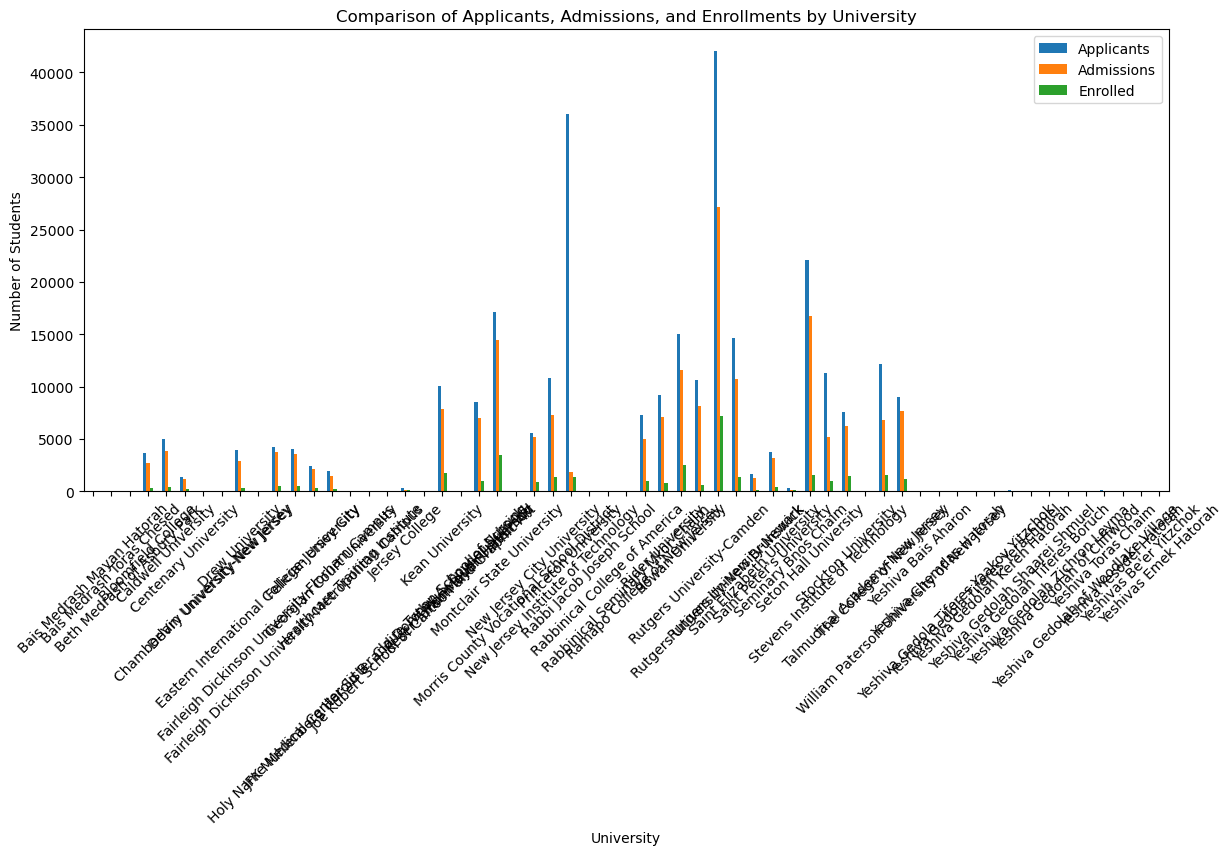

In [11]:
df = pd.read_csv("adm/NJ_admission_data.csv")

# Plot bar chart
plt.figure(figsize=(12, 6))
df.groupby("university_name")[["Applicants_total", "Admissions_total", "Enrolled_total"]].mean().plot(kind="bar", figsize=(14, 6))

plt.title("Comparison of Applicants, Admissions, and Enrollments by University")
plt.ylabel("Number of Students")
plt.xlabel("University")
plt.legend(["Applicants", "Admissions", "Enrolled"])
plt.xticks(rotation=45)
plt.show()


In [12]:
def get_total_admissions_for_unitid(all_data, unitid):
    df = all_data[all_data["unitid"] == unitid]

    if df.empty:
        print(f"No data found for unitid {unitid}.")
        return 0

    total_admissions = df["Admissions_total"].sum()
    return total_admissions

# Example usage:
unitid = 185828
total = get_total_admissions_for_unitid(all_data, unitid)
print(f"Total admissions for unitid {unitid}: {total}")


Total admissions for unitid 185828: 43894.0


In [ ]:
def get_yearly_admissions_for_unitid(all_data, unitid):
    df = all_data[all_data["unitid"] == unitid][["year", "Admissions_total"]]
    return df.sort_values("year")

# Print
print(get_yearly_admissions_for_unitid(all_data, unitid))


     year  Admissions_total
95   2018            5171.0
96   2019            5971.0
97   2020            6800.0
98   2021            8005.0
99   2022            8585.0
100  2023            9362.0
